### Multi-Class Classification

In [1]:
#Import libraries to open data file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import pprint
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

### One vs all classification: for feature selection

#### For AFFF-GW

In [2]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [3]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: AFFF-GW


In [4]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [5]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]

#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)
#data_1 = pd.DataFrame(data_1)
#data_1.to_csv('log10_dat.csv', index=False)

In [6]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Random Forest 
n_estimators = [100,1000, 2000]
max_features = ['sqrt', 'log2', 'auto']
#min_samples_leaf = [3, 4, 5]
#min_samples_split = [2, 4]
#bootstrap = [True, False]

grid = dict(n_estimators = n_estimators, max_features = max_features)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))



for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = RandomForestClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Random Forest model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.891667 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.883333 using {'max_features': 'auto', 'n_estimators': 2000}
Best: 0.883333 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.866667 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.883333 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.883333 using {'max_features': 'auto', 'n_estimators': 100}
Best: 0.883333 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.850000 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.891667 using {'max_features': 'auto', 'n_estimators': 100}
Best: 0.866667 using {'max_features': 'sqrt', 'n_estimators': 1000}


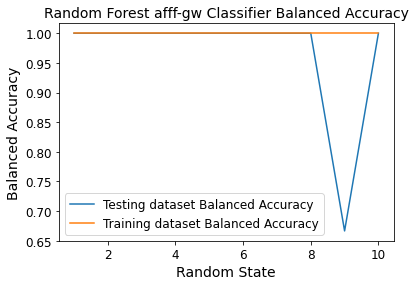

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [7]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Random Forest afff-gw Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RandomForest-Tuning-T1-gw.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [8]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         1.         1.         1.         1.         1.
 1.         1.         0.66666667 1.        ]


Feature: 0, Score: 0.03258
Feature: 1, Score: 0.01111
Feature: 2, Score: 0.02672
Feature: 3, Score: 0.04249
Feature: 4, Score: 0.07283
Feature: 5, Score: 0.00395
Feature: 6, Score: 0.02781
Feature: 7, Score: 0.02292
Feature: 8, Score: 0.00530
Feature: 9, Score: 0.02757
Feature: 10, Score: 0.09060
Feature: 11, Score: 0.00752
Feature: 12, Score: 0.00404
Feature: 13, Score: 0.07749
Feature: 14, Score: 0.05538
Feature: 15, Score: 0.04096
Feature: 16, Score: 0.02310
Feature: 17, Score: 0.00647
Feature: 18, Score: 0.01574
Feature: 19, Score: 0.01619
Feature: 20, Score: 0.06821
Feature: 21, Score: 0.02096
Feature: 22, Score: 0.02901
Feature: 23, Score: 0.00996
Feature: 24, Score: 0.00424
Feature: 25, Score: 0.00165
Feature: 26, Score: 0.03370
Feature: 27, Score: 0.00093
Feature: 28, Score: 0.00228
Feature: 29, Score: 0.00314
Feature: 30, Score: 0.00858
Feature: 31, Score: 0.01717
Feature: 32, Score: 0.00257
Feature: 33, Score: 0.00041
Feature: 34, Score: 0.01408
Feature: 35, Score: 0.01243
Fe

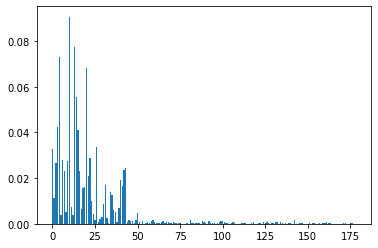

In [9]:
#Now running optimized model over the entire dataset
model = RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt')
# fit the model
model.fit(data_1, target_1.ravel())
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.02819, Standard Deviation: 0.00367
Feature 1: Average Score: 0.01246, Standard Deviation: 0.00250
Feature 2: Average Score: 0.02532, Standard Deviation: 0.00323
Feature 3: Average Score: 0.04231, Standard Deviation: 0.00525
Feature 4: Average Score: 0.07325, Standard Deviation: 0.00726
Feature 5: Average Score: 0.00397, Standard Deviation: 0.00079
Feature 6: Average Score: 0.02591, Standard Deviation: 0.00371
Feature 7: Average Score: 0.02448, Standard Deviation: 0.00300
Feature 8: Average Score: 0.00473, Standard Deviation: 0.00103
Feature 9: Average Score: 0.02585, Standard Deviation: 0.00345
Feature 10: Average Score: 0.09505, Standard Deviation: 0.00787
Feature 11: Average Score: 0.00763, Standard Deviation: 0.00115
Feature 12: Average Score: 0.00472, Standard Deviation: 0.00101
Feature 13: Average Score: 0.07476, Standard Deviation: 0.00662
Feature 14: Average Score: 0.05402, Standard Deviation: 0.00609
Feature 15: Average Score: 0.04155, Standard Devia

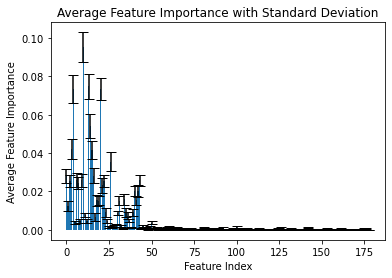

In [10]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=1000, max_features='sqrt')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [11]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 0.09505, Standard Deviation: 0.00787
Feature: 312.972236/8.1, Mean Score: 0.07476, Standard Deviation: 0.00662
Feature: 448.932612/10.45, Mean Score: 0.07332, Standard Deviation: 0.00576
Feature: 348.939226/8.16, Mean Score: 0.07325, Standard Deviation: 0.00726
Feature: 397.951371/10.99, Mean Score: 0.05402, Standard Deviation: 0.00609
Feature: 412.965446/10.35, Mean Score: 0.04231, Standard Deviation: 0.00525
Feature: 297.958267/8.5, Mean Score: 0.04155, Standard Deviation: 0.00481
Feature: 460.933583/10.29, Mean Score: 0.03557, Standard Deviation: 0.00498
Feature: 248.945994/6.66, Mean Score: 0.02830, Standard Deviation: 0.00407
Feature: 498.92902/11.61, Mean Score: 0.02819, Standard Deviation: 0.00367


In [12]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 397.951243/11.28, Mean Score: 0.09505, Standard Deviation: 0.00787
Feature: 312.972236/8.1, Mean Score: 0.07476, Standard Deviation: 0.00662
Feature: 448.932612/10.45, Mean Score: 0.07332, Standard Deviation: 0.00576
Feature: 348.939226/8.16, Mean Score: 0.07325, Standard Deviation: 0.00726
Feature: 397.951371/10.99, Mean Score: 0.05402, Standard Deviation: 0.00609
Feature: 412.965446/10.35, Mean Score: 0.04231, Standard Deviation: 0.00525
Feature: 297.958267/8.5, Mean Score: 0.04155, Standard Deviation: 0.00481
Feature: 460.933583/10.29, Mean Score: 0.03557, Standard Deviation: 0.00498
Feature: 248.945994/6.66, Mean Score: 0.02830, Standard Deviation: 0.00407
Feature: 498.92902/11.61, Mean Score: 0.02819, Standard Deviation: 0.00367


Top Features with Significant Importance:
1. Feature: 397.951243/11.28, Mean Score: 0.09505, Standard Deviation: 0.00787
2. Feature: 312.972236/8.1, Mean Score: 0.07476, Standard Deviation: 0.00662
3. Feature: 448.932612/10.45, Mean Score: 0.07332, Standard Deviation: 0.00576
4. Feature: 348.939226/8.16, Mean Score: 0.07325, Standard Deviation: 0.00726
5. Feature: 397.951371/10.99, Mean Score: 0.05402, Standard Deviation: 0.00609
6. Feature: 412.965446/10.35, Mean Score: 0.04231, Standard Deviation: 0.00525
7. Feature: 297.958267/8.5, Mean Score: 0.04155, Standard Deviation: 0.00481
8. Feature: 460.933583/10.29, Mean Score: 0.03557, Standard Deviation: 0.00498
9. Feature: 248.945994/6.66, Mean Score: 0.02830, Standard Deviation: 0.00407
10. Feature: 498.92902/11.61, Mean Score: 0.02819, Standard Deviation: 0.00367
11. Feature: 498.929359/11.15, Mean Score: 0.02591, Standard Deviation: 0.00371
12. Feature: 298.942577/7.31, Mean Score: 0.02585, Standard Deviation: 0.00345
13. Feature: 31

124. Feature: 201.022727/6.54, Mean Score: 0.00023, Standard Deviation: 0.00018
125. Feature: 210.135849/8.03, Mean Score: 0.00023, Standard Deviation: 0.00018
126. Feature: 219.174255/14, Mean Score: 0.00022, Standard Deviation: 0.00016
127. Feature: 161.133337/9.32, Mean Score: 0.00021, Standard Deviation: 0.00016
128. Feature: 289.144149/7.43, Mean Score: 0.00020, Standard Deviation: 0.00015
129. Feature: 255.069419/7.21, Mean Score: 0.00019, Standard Deviation: 0.00016
130. Feature: 409.242656/6.99, Mean Score: 0.00019, Standard Deviation: 0.00018
131. Feature: 261.113152/6.9, Mean Score: 0.00019, Standard Deviation: 0.00015
132. Feature: 313.146047/9.34, Mean Score: 0.00019, Standard Deviation: 0.00016
133. Feature: 291.19578/12.22, Mean Score: 0.00019, Standard Deviation: 0.00016
134. Feature: 249.058758/7.55, Mean Score: 0.00018, Standard Deviation: 0.00014
135. Feature: 287.164623/10.13, Mean Score: 0.00018, Standard Deviation: 0.00014
136. Feature: 167.106876/8.16, Mean Score:

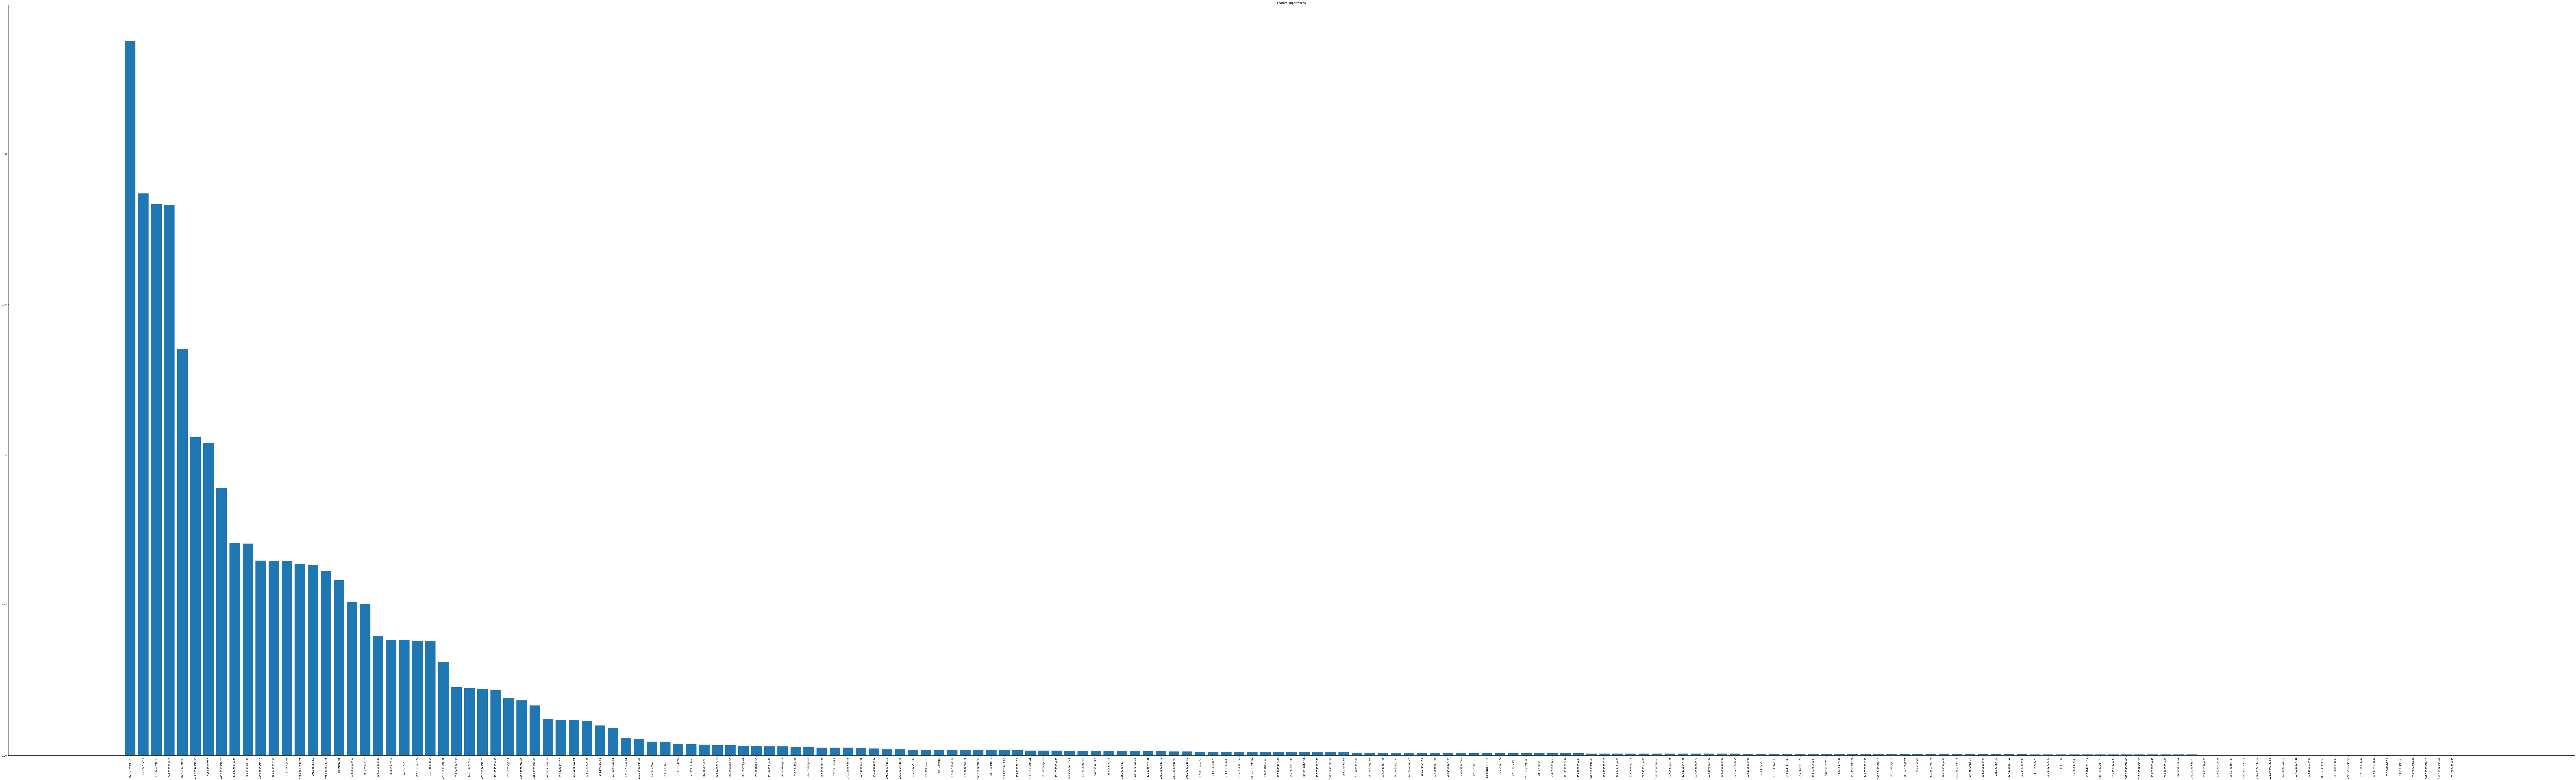

In [13]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores-rf-gw.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_gw.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [14]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff.xlsx', index=False)

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [17]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [18]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


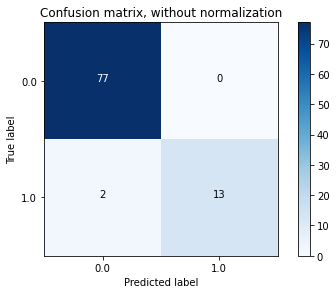

Normalized confusion matrix


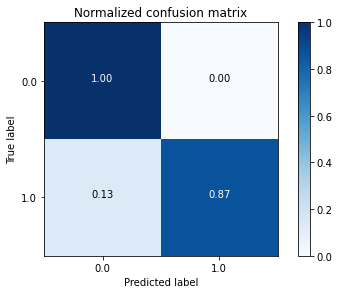

In [19]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

#### For LL

In [20]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [21]:
#Prompt user for source type of interest (GW, LL, BL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: LL


In [22]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [23]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [24]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Random Forest 
n_estimators = [100,1000, 2000]
max_features = ['sqrt', 'log2', 'auto']
#min_samples_leaf = [3, 4, 5]
#min_samples_split = [2, 4]
#bootstrap = [True, False]

#Create a custom scorer for balanced accuracy
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

grid = dict(n_estimators = n_estimators, max_features = max_features)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))

for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = RandomForestClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Random Forest model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.966667 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.953333 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.966667 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.966667 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.953333 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.966667 using {'max_features': 'log2', 'n_estimators': 1000}
Best: 0.960000 using {'max_features': 'sqrt', 'n_estimators': 2000}
Best: 0.946667 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.953333 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.966667 using {'max_features': 'sqrt', 'n_estimators': 100}


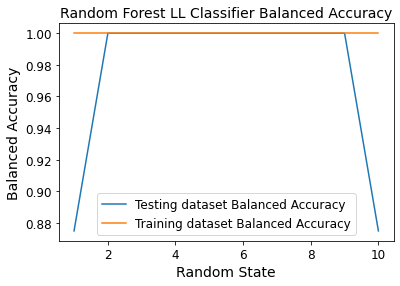

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 2
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.88 1.   1.   1.   1.   1.   1.   1.   1.   0.88]


In [26]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Random Forest LL Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RandomForest-Tuning-LL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

print(train_balanced_accuracy)
print(test_balanced_accuracy)

Feature: 0, Score: 0.00156
Feature: 1, Score: 0.00017
Feature: 2, Score: 0.00036
Feature: 3, Score: 0.00163
Feature: 4, Score: 0.00073
Feature: 5, Score: 0.00104
Feature: 6, Score: 0.00025
Feature: 7, Score: 0.00049
Feature: 8, Score: 0.00064
Feature: 9, Score: 0.00085
Feature: 10, Score: 0.00096
Feature: 11, Score: 0.00185
Feature: 12, Score: 0.00813
Feature: 13, Score: 0.00222
Feature: 14, Score: 0.00033
Feature: 15, Score: 0.00066
Feature: 16, Score: 0.00026
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00306
Feature: 19, Score: 0.00171
Feature: 20, Score: 0.00023
Feature: 21, Score: 0.00032
Feature: 22, Score: 0.00014
Feature: 23, Score: 0.00007
Feature: 24, Score: 0.00032
Feature: 25, Score: 0.01944
Feature: 26, Score: 0.00008
Feature: 27, Score: 0.00075
Feature: 28, Score: 0.00185
Feature: 29, Score: 0.00130
Feature: 30, Score: 0.00392
Feature: 31, Score: 0.00009
Feature: 32, Score: 0.00076
Feature: 33, Score: 0.00125
Feature: 34, Score: 0.00024
Feature: 35, Score: 0.00015
Fe

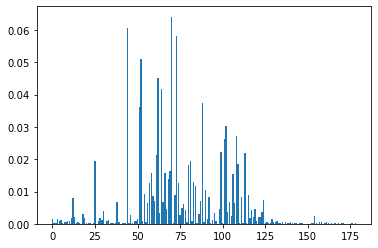

In [27]:
#Now running optimized model over the entire dataset
model = RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt')
# fit the model
model.fit(data_1, target_1.ravel())
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00136, Standard Deviation: 0.00040
Feature 1: Average Score: 0.00020, Standard Deviation: 0.00014
Feature 2: Average Score: 0.00038, Standard Deviation: 0.00023
Feature 3: Average Score: 0.00168, Standard Deviation: 0.00041
Feature 4: Average Score: 0.00049, Standard Deviation: 0.00023
Feature 5: Average Score: 0.00123, Standard Deviation: 0.00033
Feature 6: Average Score: 0.00041, Standard Deviation: 0.00021
Feature 7: Average Score: 0.00050, Standard Deviation: 0.00023
Feature 8: Average Score: 0.00032, Standard Deviation: 0.00017
Feature 9: Average Score: 0.00056, Standard Deviation: 0.00026
Feature 10: Average Score: 0.00059, Standard Deviation: 0.00030
Feature 11: Average Score: 0.00261, Standard Deviation: 0.00087
Feature 12: Average Score: 0.00801, Standard Deviation: 0.00208
Feature 13: Average Score: 0.00256, Standard Deviation: 0.00068
Feature 14: Average Score: 0.00034, Standard Deviation: 0.00022
Feature 15: Average Score: 0.00046, Standard Devia

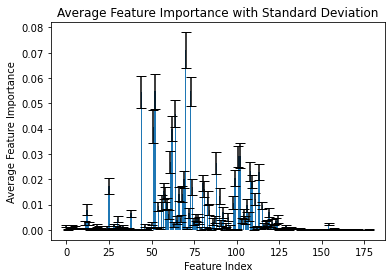

In [28]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=1000, max_features='sqrt')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [29]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 235.043254/7.03, Mean Score: 0.07109, Standard Deviation: 0.00700
Feature: 151.087345/6.54, Mean Score: 0.05478, Standard Deviation: 0.00700
Feature: 221.027535/6.68, Mean Score: 0.05476, Standard Deviation: 0.00570
Feature: 185.027509/6.37, Mean Score: 0.05429, Standard Deviation: 0.00633
Feature: 277.144183/7.9, Mean Score: 0.04590, Standard Deviation: 0.00528
Feature: 199.043174/6.74, Mean Score: 0.04076, Standard Deviation: 0.00652
Feature: 235.136869/10.02, Mean Score: 0.03989, Standard Deviation: 0.00496
Feature: 289.180401/9, Mean Score: 0.02931, Standard Deviation: 0.00484
Feature: 209.1544/10.12, Mean Score: 0.02908, Standard Deviation: 0.00422
Feature: 198.059185/7.65, Mean Score: 0.02687, Standard Deviation: 0.00446


In [30]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 235.043254/7.03, Mean Score: 0.07109, Standard Deviation: 0.00700
Feature: 151.087345/6.54, Mean Score: 0.05478, Standard Deviation: 0.00700
Feature: 221.027535/6.68, Mean Score: 0.05476, Standard Deviation: 0.00570
Feature: 185.027509/6.37, Mean Score: 0.05429, Standard Deviation: 0.00633
Feature: 277.144183/7.9, Mean Score: 0.04590, Standard Deviation: 0.00528
Feature: 199.043174/6.74, Mean Score: 0.04076, Standard Deviation: 0.00652
Feature: 235.136869/10.02, Mean Score: 0.03989, Standard Deviation: 0.00496
Feature: 289.180401/9, Mean Score: 0.02931, Standard Deviation: 0.00484
Feature: 209.1544/10.12, Mean Score: 0.02908, Standard Deviation: 0.00422
Feature: 198.059185/7.65, Mean Score: 0.02687, Standard Deviation: 0.00446


Top Features with Significant Importance:
1. Feature: 235.043254/7.03, Mean Score: 0.07109, Standard Deviation: 0.00700
2. Feature: 151.087345/6.54, Mean Score: 0.05478, Standard Deviation: 0.00700
3. Feature: 221.027535/6.68, Mean Score: 0.05476, Standard Deviation: 0.00570
4. Feature: 185.027509/6.37, Mean Score: 0.05429, Standard Deviation: 0.00633
5. Feature: 277.144183/7.9, Mean Score: 0.04590, Standard Deviation: 0.00528
6. Feature: 199.043174/6.74, Mean Score: 0.04076, Standard Deviation: 0.00652
7. Feature: 235.136869/10.02, Mean Score: 0.03989, Standard Deviation: 0.00496
8. Feature: 289.180401/9, Mean Score: 0.02931, Standard Deviation: 0.00484
9. Feature: 209.1544/10.12, Mean Score: 0.02908, Standard Deviation: 0.00422
10. Feature: 198.059185/7.65, Mean Score: 0.02687, Standard Deviation: 0.00446
11. Feature: 236.096046/7.56, Mean Score: 0.02638, Standard Deviation: 0.00431
12. Feature: 213.058843/7.06, Mean Score: 0.02312, Standard Deviation: 0.00384
13. Feature: 233.118197

118. Feature: 361.237403/16.43, Mean Score: 0.00034, Standard Deviation: 0.00015
119. Feature: 211.169636/13.44, Mean Score: 0.00033, Standard Deviation: 0.00016
120. Feature: 223.169592/13.03, Mean Score: 0.00032, Standard Deviation: 0.00019
121. Feature: 412.965695/10.3, Mean Score: 0.00032, Standard Deviation: 0.00017
122. Feature: 204.946083/7.46, Mean Score: 0.00032, Standard Deviation: 0.00017
123. Feature: 321.151899/13.38, Mean Score: 0.00032, Standard Deviation: 0.00019
124. Feature: 231.137876/11.76, Mean Score: 0.00031, Standard Deviation: 0.00016
125. Feature: 149.060484/6.58, Mean Score: 0.00031, Standard Deviation: 0.00014
126. Feature: 173.118072/6.61, Mean Score: 0.00031, Standard Deviation: 0.00016
127. Feature: 381.244907/17.39, Mean Score: 0.00030, Standard Deviation: 0.00016
128. Feature: 199.133412/7, Mean Score: 0.00030, Standard Deviation: 0.00020
129. Feature: 367.233214/8.08, Mean Score: 0.00030, Standard Deviation: 0.00029
130. Feature: 299.095256/6.65, Mean S

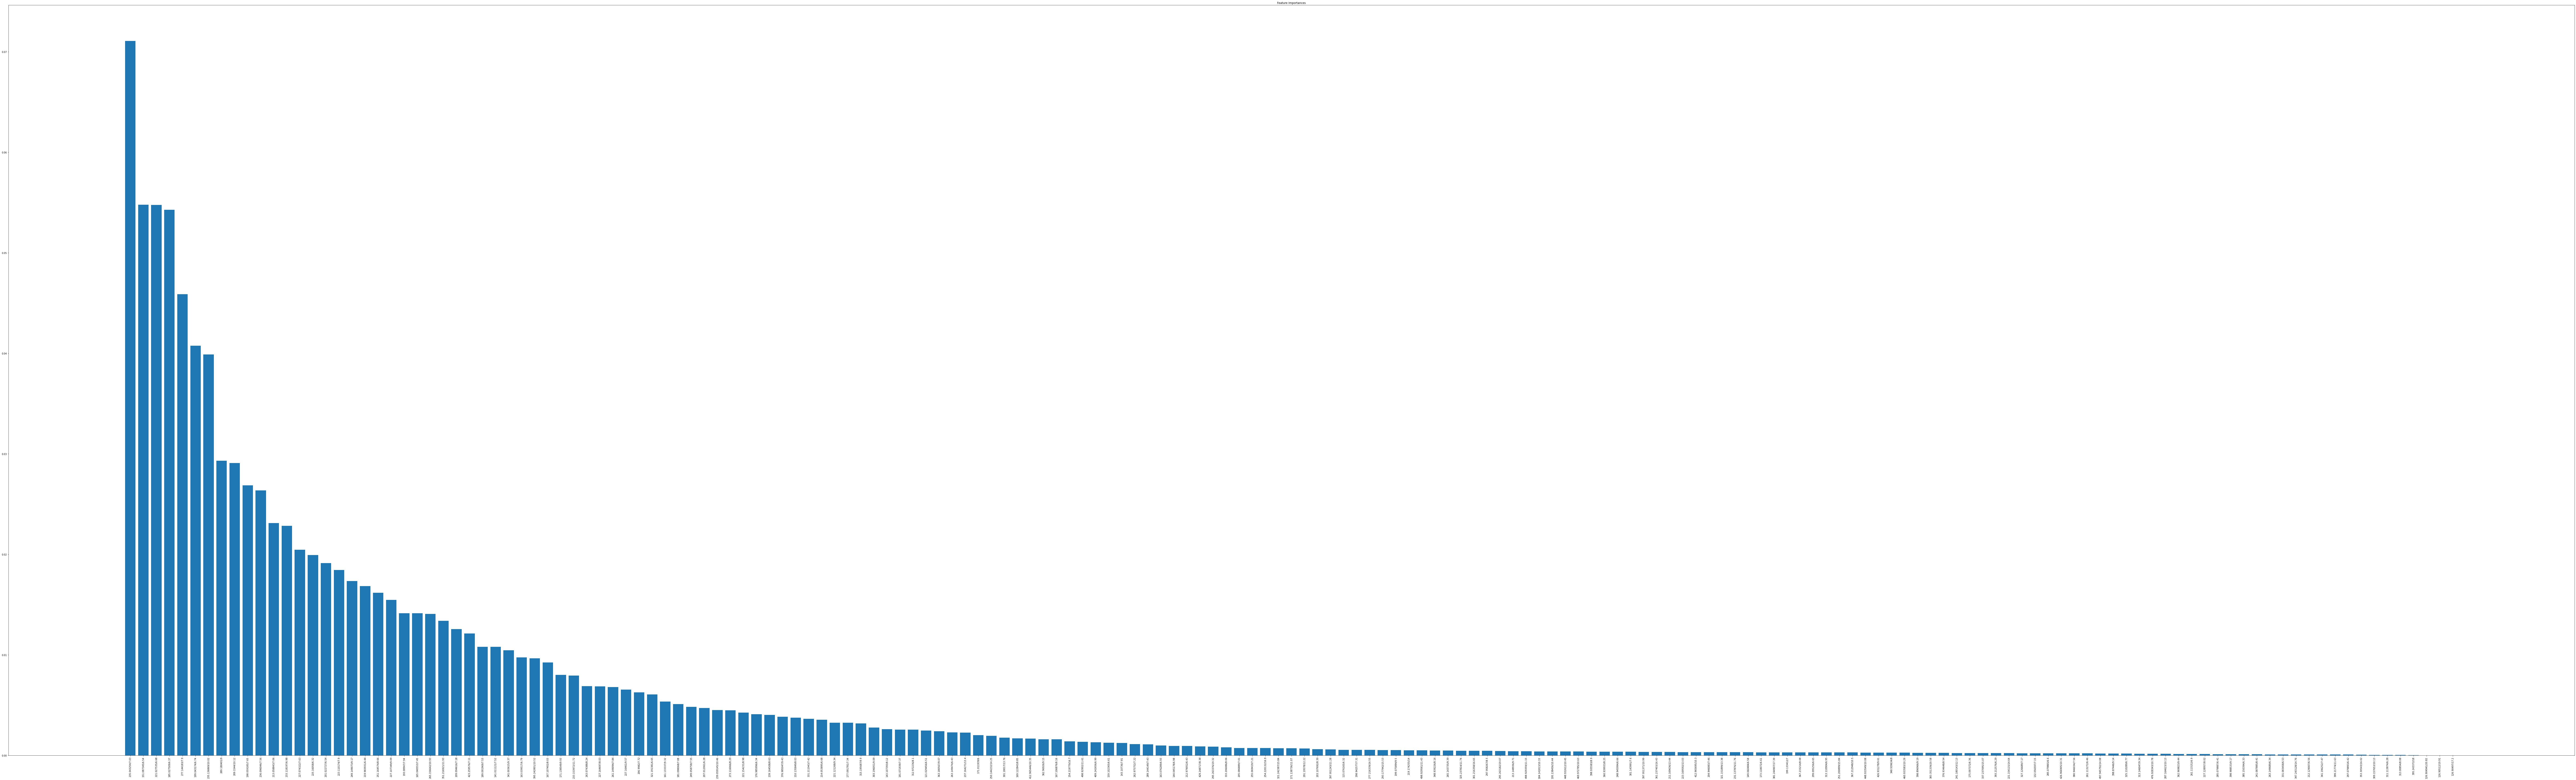

In [31]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores-RF-LL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_LL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [32]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_LL.xlsx', index=False)

In [33]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [34]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [35]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


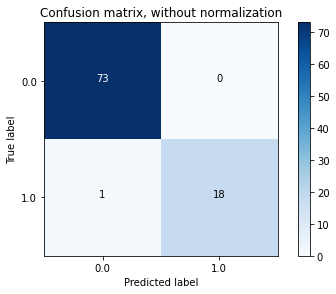

Normalized confusion matrix


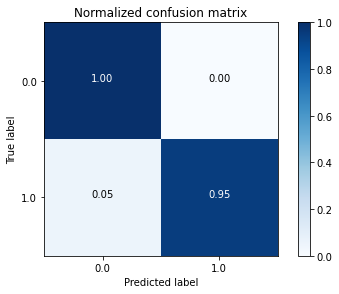

In [36]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For BL

In [37]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [38]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: BL


In [39]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [40]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [41]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Random Forest 
n_estimators = [100,1000, 2000]
max_features = ['sqrt', 'log2', 'auto']
#min_samples_leaf = [3, 4, 5]
#min_samples_split = [2, 4]
#bootstrap = [True, False]

#Create a custom scorer for balanced accuracy
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

grid = dict(n_estimators = n_estimators, max_features = max_features)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))

for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.3, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = RandomForestClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Random Forest model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.838889 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.872222 using {'max_features': 'sqrt', 'n_estimators': 2000}
Best: 0.802778 using {'max_features': 'sqrt', 'n_estimators': 2000}
Best: 0.822222 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.786111 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.775000 using {'max_features': 'auto', 'n_estimators': 1000}
Best: 0.777778 using {'max_features': 'log2', 'n_estimators': 2000}
Best: 0.813889 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.761111 using {'max_features': 'sqrt', 'n_estimators': 2000}
Best: 0.791667 using {'max_features': 'auto', 'n_estimators': 2000}


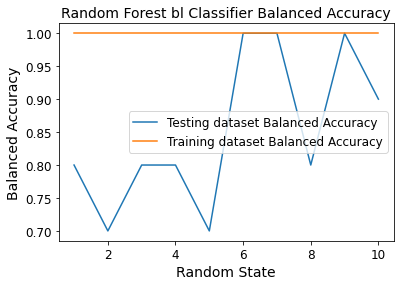

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 6


In [42]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Random Forest bl Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RandomForest-Tuning-T1-BL.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [43]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.8 0.7 0.8 0.8 0.7 1.  1.  0.8 1.  0.9]


Feature: 0, Score: 0.03185
Feature: 1, Score: 0.00200
Feature: 2, Score: 0.00315
Feature: 3, Score: 0.01230
Feature: 4, Score: 0.00555
Feature: 5, Score: 0.00730
Feature: 6, Score: 0.00222
Feature: 7, Score: 0.00411
Feature: 8, Score: 0.00864
Feature: 9, Score: 0.00617
Feature: 10, Score: 0.00166
Feature: 11, Score: 0.00742
Feature: 12, Score: 0.00657
Feature: 13, Score: 0.01396
Feature: 14, Score: 0.00082
Feature: 15, Score: 0.00129
Feature: 16, Score: 0.00226
Feature: 17, Score: 0.00076
Feature: 18, Score: 0.01002
Feature: 19, Score: 0.00874
Feature: 20, Score: 0.00259
Feature: 21, Score: 0.00064
Feature: 22, Score: 0.00055
Feature: 23, Score: 0.00029
Feature: 24, Score: 0.00396
Feature: 25, Score: 0.00611
Feature: 26, Score: 0.00087
Feature: 27, Score: 0.00877
Feature: 28, Score: 0.00718
Feature: 29, Score: 0.00211
Feature: 30, Score: 0.00565
Feature: 31, Score: 0.00010
Feature: 32, Score: 0.00422
Feature: 33, Score: 0.04265
Feature: 34, Score: 0.00034
Feature: 35, Score: 0.00036
Fe

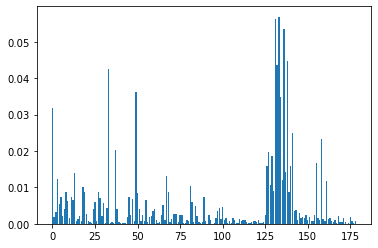

In [44]:
#Now running optimized model over the entire dataset
model = RandomForestClassifier(n_estimators = 2000, max_features = 'sqrt')
# fit the model
model.fit(data_1, target_1.ravel())
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.03050, Standard Deviation: 0.00174
Feature 1: Average Score: 0.00174, Standard Deviation: 0.00043
Feature 2: Average Score: 0.00387, Standard Deviation: 0.00067
Feature 3: Average Score: 0.01088, Standard Deviation: 0.00097
Feature 4: Average Score: 0.00378, Standard Deviation: 0.00063
Feature 5: Average Score: 0.00810, Standard Deviation: 0.00083
Feature 6: Average Score: 0.00212, Standard Deviation: 0.00042
Feature 7: Average Score: 0.00456, Standard Deviation: 0.00053
Feature 8: Average Score: 0.00844, Standard Deviation: 0.00071
Feature 9: Average Score: 0.00667, Standard Deviation: 0.00087
Feature 10: Average Score: 0.00155, Standard Deviation: 0.00036
Feature 11: Average Score: 0.00719, Standard Deviation: 0.00072
Feature 12: Average Score: 0.00602, Standard Deviation: 0.00067
Feature 13: Average Score: 0.01395, Standard Deviation: 0.00134
Feature 14: Average Score: 0.00085, Standard Deviation: 0.00023
Feature 15: Average Score: 0.00103, Standard Devia

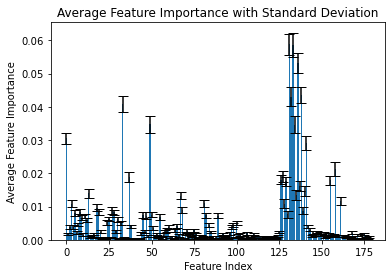

In [45]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=2000, max_features='sqrt')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [46]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 367.212948/10.5, Mean Score: 0.05874, Standard Deviation: 0.00316
Feature: 219.174255/14, Mean Score: 0.05866, Standard Deviation: 0.00361
Feature: 231.137876/11.76, Mean Score: 0.05326, Standard Deviation: 0.00306
Feature: 383.351339/20.58, Mean Score: 0.04356, Standard Deviation: 0.00250
Feature: 295.263376/19.32, Mean Score: 0.04308, Standard Deviation: 0.00294
Feature: 254.219779/16.7, Mean Score: 0.04089, Standard Deviation: 0.00247
Feature: 144.045178/6.98, Mean Score: 0.03469, Standard Deviation: 0.00257
Feature: 295.263182/19.07, Mean Score: 0.03459, Standard Deviation: 0.00253
Feature: 498.92902/11.61, Mean Score: 0.03050, Standard Deviation: 0.00174
Feature: 381.244907/17.39, Mean Score: 0.02909, Standard Deviation: 0.00203


In [47]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 367.212948/10.5, Mean Score: 0.05874, Standard Deviation: 0.00316
Feature: 219.174255/14, Mean Score: 0.05866, Standard Deviation: 0.00361
Feature: 231.137876/11.76, Mean Score: 0.05326, Standard Deviation: 0.00306
Feature: 383.351339/20.58, Mean Score: 0.04356, Standard Deviation: 0.00250
Feature: 295.263376/19.32, Mean Score: 0.04308, Standard Deviation: 0.00294
Feature: 254.219779/16.7, Mean Score: 0.04089, Standard Deviation: 0.00247
Feature: 144.045178/6.98, Mean Score: 0.03469, Standard Deviation: 0.00257
Feature: 295.263182/19.07, Mean Score: 0.03459, Standard Deviation: 0.00253
Feature: 498.92902/11.61, Mean Score: 0.03050, Standard Deviation: 0.00174
Feature: 381.244907/17.39, Mean Score: 0.02909, Standard Deviation: 0.00203


Top Features with Significant Importance:
1. Feature: 367.212948/10.5, Mean Score: 0.05874, Standard Deviation: 0.00316
2. Feature: 219.174255/14, Mean Score: 0.05866, Standard Deviation: 0.00361
3. Feature: 231.137876/11.76, Mean Score: 0.05326, Standard Deviation: 0.00306
4. Feature: 383.351339/20.58, Mean Score: 0.04356, Standard Deviation: 0.00250
5. Feature: 295.263376/19.32, Mean Score: 0.04308, Standard Deviation: 0.00294
6. Feature: 254.219779/16.7, Mean Score: 0.04089, Standard Deviation: 0.00247
7. Feature: 144.045178/6.98, Mean Score: 0.03469, Standard Deviation: 0.00257
8. Feature: 295.263182/19.07, Mean Score: 0.03459, Standard Deviation: 0.00253
9. Feature: 498.92902/11.61, Mean Score: 0.03050, Standard Deviation: 0.00174
10. Feature: 381.244907/17.39, Mean Score: 0.02909, Standard Deviation: 0.00203
11. Feature: 241.180143/12.13, Mean Score: 0.02123, Standard Deviation: 0.00213
12. Feature: 213.148936/9.71, Mean Score: 0.01905, Standard Deviation: 0.00170
13. Feature: 29

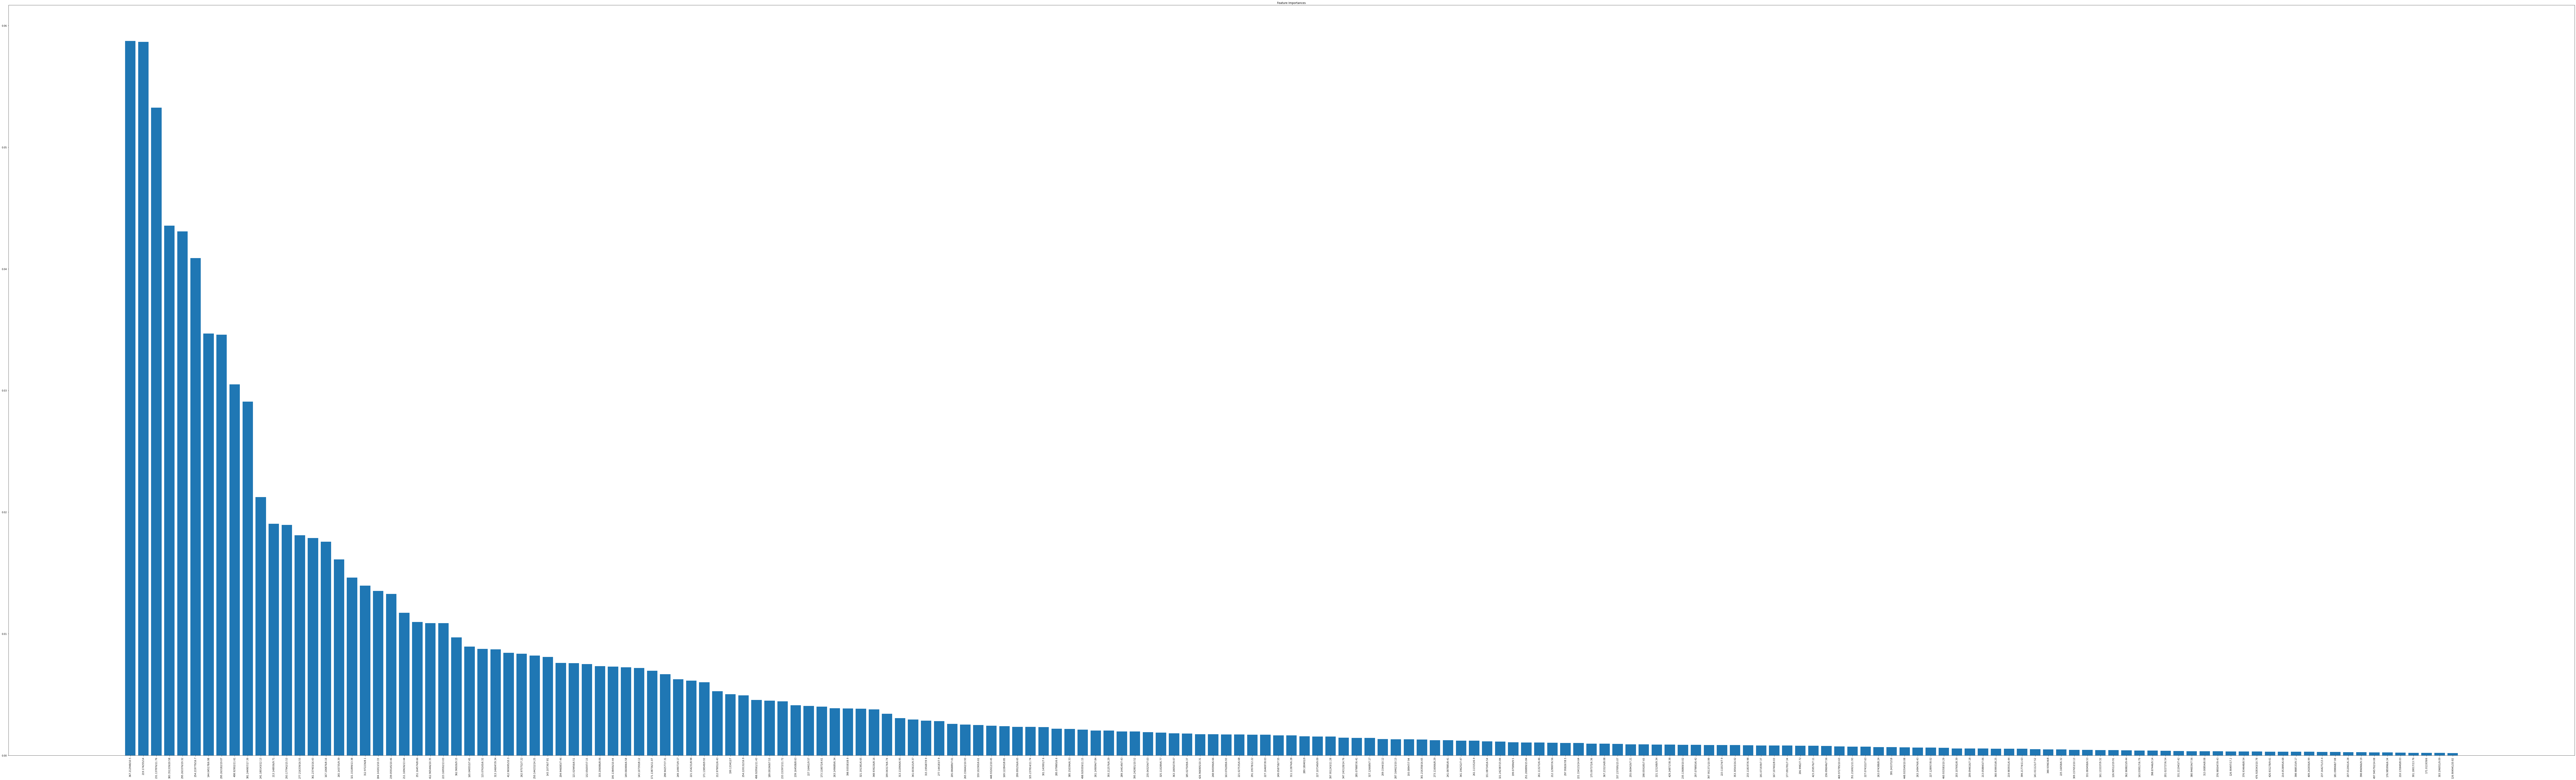

In [48]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_BL.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_BL.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [49]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_BL.xlsx', index=False)

In [50]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = RandomForestClassifier(n_estimators = 2000, max_features = 'sqrt')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [51]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [52]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


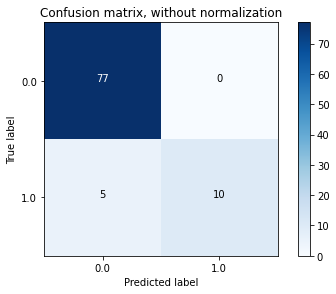

Normalized confusion matrix


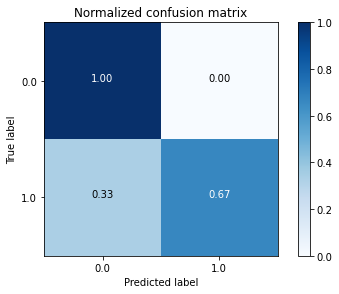

In [53]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### WWTP

In [54]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [55]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: WWTP


In [56]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [57]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [58]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Random Forest 
n_estimators = [100,1000, 2000]
max_features = ['sqrt', 'log2', 'auto']
#min_samples_leaf = [3, 4, 5]
#min_samples_split = [2, 4]
#bootstrap = [True, False]

#Create a custom scorer for balanced accuracy
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

grid = dict(n_estimators = n_estimators, max_features = max_features)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))

for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = RandomForestClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Random Forest model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.938246 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.937982 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.906491 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.911228 using {'max_features': 'log2', 'n_estimators': 1000}
Best: 0.947807 using {'max_features': 'log2', 'n_estimators': 1000}
Best: 0.911316 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.904737 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.904737 using {'max_features': 'log2', 'n_estimators': 100}
Best: 0.911404 using {'max_features': 'log2', 'n_estimators': 2000}
Best: 0.924561 using {'max_features': 'log2', 'n_estimators': 100}


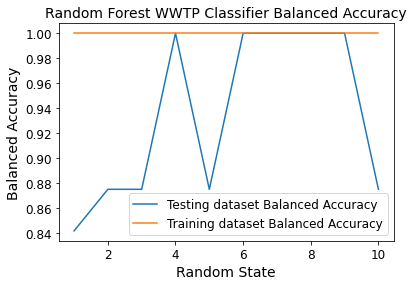

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 4


In [59]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Random Forest WWTP Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RandomForest-Tuning-wwtp.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [60]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.84 0.88 0.88 1.   0.88 1.   1.   1.   1.   0.88]


Feature: 0, Score: 0.01496
Feature: 1, Score: 0.00060
Feature: 2, Score: 0.00832
Feature: 3, Score: 0.02704
Feature: 4, Score: 0.00385
Feature: 5, Score: 0.01578
Feature: 6, Score: 0.00435
Feature: 7, Score: 0.00476
Feature: 8, Score: 0.00857
Feature: 9, Score: 0.00650
Feature: 10, Score: 0.00339
Feature: 11, Score: 0.01502
Feature: 12, Score: 0.02018
Feature: 13, Score: 0.00844
Feature: 14, Score: 0.00194
Feature: 15, Score: 0.00141
Feature: 16, Score: 0.00005
Feature: 17, Score: 0.00003
Feature: 18, Score: 0.00581
Feature: 19, Score: 0.02768
Feature: 20, Score: 0.00033
Feature: 21, Score: 0.00011
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00191
Feature: 25, Score: 0.01633
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.02141
Feature: 28, Score: 0.02177
Feature: 29, Score: 0.00990
Feature: 30, Score: 0.02617
Feature: 31, Score: 0.00003
Feature: 32, Score: 0.00888
Feature: 33, Score: 0.00123
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

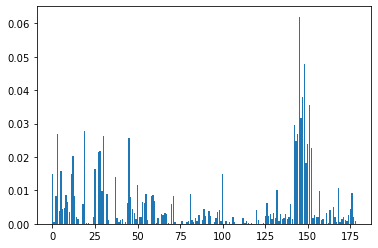

In [61]:
#Now running optimized model over the entire dataset
model = RandomForestClassifier(n_estimators = 100, max_features = 'log2')
# fit the model
model.fit(data_1, target_1.ravel())
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.01361, Standard Deviation: 0.00533
Feature 1: Average Score: 0.00376, Standard Deviation: 0.00233
Feature 2: Average Score: 0.00406, Standard Deviation: 0.00242
Feature 3: Average Score: 0.01374, Standard Deviation: 0.00595
Feature 4: Average Score: 0.00223, Standard Deviation: 0.00173
Feature 5: Average Score: 0.01239, Standard Deviation: 0.00356
Feature 6: Average Score: 0.00276, Standard Deviation: 0.00187
Feature 7: Average Score: 0.00149, Standard Deviation: 0.00130
Feature 8: Average Score: 0.01158, Standard Deviation: 0.00477
Feature 9: Average Score: 0.00545, Standard Deviation: 0.00248
Feature 10: Average Score: 0.00195, Standard Deviation: 0.00128
Feature 11: Average Score: 0.02443, Standard Deviation: 0.00750
Feature 12: Average Score: 0.01950, Standard Deviation: 0.00527
Feature 13: Average Score: 0.01301, Standard Deviation: 0.00484
Feature 14: Average Score: 0.00073, Standard Deviation: 0.00067
Feature 15: Average Score: 0.00079, Standard Devia

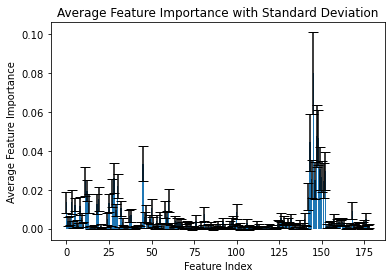

In [62]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=100, max_features='log2')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [63]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 285.079865/6.6, Mean Score: 0.08014, Standard Deviation: 0.02093
Feature: 299.095256/6.65, Mean Score: 0.04777, Standard Deviation: 0.01610
Feature: 285.079887/6.41, Mean Score: 0.04686, Standard Deviation: 0.01405
Feature: 313.110904/6.95, Mean Score: 0.04449, Standard Deviation: 0.01469
Feature: 132.056597/7.15, Mean Score: 0.03339, Standard Deviation: 0.00913
Feature: 393.212576/6.29, Mean Score: 0.03085, Standard Deviation: 0.01111
Feature: 297.079893/6.42, Mean Score: 0.02963, Standard Deviation: 0.00977
Feature: 287.164623/10.13, Mean Score: 0.02681, Standard Deviation: 0.00803
Feature: 250.144232/14.25, Mean Score: 0.02609, Standard Deviation: 0.00765
Feature: 212.129007/6.56, Mean Score: 0.02549, Standard Deviation: 0.00978


In [64]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 285.079865/6.6, Mean Score: 0.08014, Standard Deviation: 0.02093
Feature: 299.095256/6.65, Mean Score: 0.04777, Standard Deviation: 0.01610
Feature: 285.079887/6.41, Mean Score: 0.04686, Standard Deviation: 0.01405
Feature: 313.110904/6.95, Mean Score: 0.04449, Standard Deviation: 0.01469
Feature: 132.056597/7.15, Mean Score: 0.03339, Standard Deviation: 0.00913
Feature: 393.212576/6.29, Mean Score: 0.03085, Standard Deviation: 0.01111
Feature: 297.079893/6.42, Mean Score: 0.02963, Standard Deviation: 0.00977
Feature: 287.164623/10.13, Mean Score: 0.02681, Standard Deviation: 0.00803
Feature: 250.144232/14.25, Mean Score: 0.02609, Standard Deviation: 0.00765
Feature: 212.129007/6.56, Mean Score: 0.02549, Standard Deviation: 0.00978


Top Features with Significant Importance:
1. Feature: 285.079865/6.6, Mean Score: 0.08014, Standard Deviation: 0.02093
2. Feature: 299.095256/6.65, Mean Score: 0.04777, Standard Deviation: 0.01610
3. Feature: 285.079887/6.41, Mean Score: 0.04686, Standard Deviation: 0.01405
4. Feature: 313.110904/6.95, Mean Score: 0.04449, Standard Deviation: 0.01469
5. Feature: 132.056597/7.15, Mean Score: 0.03339, Standard Deviation: 0.00913
6. Feature: 393.212576/6.29, Mean Score: 0.03085, Standard Deviation: 0.01111
7. Feature: 297.079893/6.42, Mean Score: 0.02963, Standard Deviation: 0.00977
8. Feature: 287.164623/10.13, Mean Score: 0.02681, Standard Deviation: 0.00803
9. Feature: 250.144232/14.25, Mean Score: 0.02609, Standard Deviation: 0.00765
10. Feature: 212.129007/6.56, Mean Score: 0.02549, Standard Deviation: 0.00978
11. Feature: 327.126689/7.17, Mean Score: 0.02492, Standard Deviation: 0.00953
12. Feature: 325.110289/6.77, Mean Score: 0.02471, Standard Deviation: 0.00900
13. Feature: 143.1

129. Feature: 219.174255/14, Mean Score: 0.00092, Standard Deviation: 0.00099
130. Feature: 227.128957/8.02, Mean Score: 0.00089, Standard Deviation: 0.00095
131. Feature: 233.153972/11.72, Mean Score: 0.00085, Standard Deviation: 0.00120
132. Feature: 333.206086/8.06, Mean Score: 0.00085, Standard Deviation: 0.00090
133. Feature: 209.1544/10.12, Mean Score: 0.00085, Standard Deviation: 0.00116
134. Feature: 248.945994/6.66, Mean Score: 0.00082, Standard Deviation: 0.00090
135. Feature: 398.988533/9.17, Mean Score: 0.00080, Standard Deviation: 0.00071
136. Feature: 297.958267/8.5, Mean Score: 0.00079, Standard Deviation: 0.00081


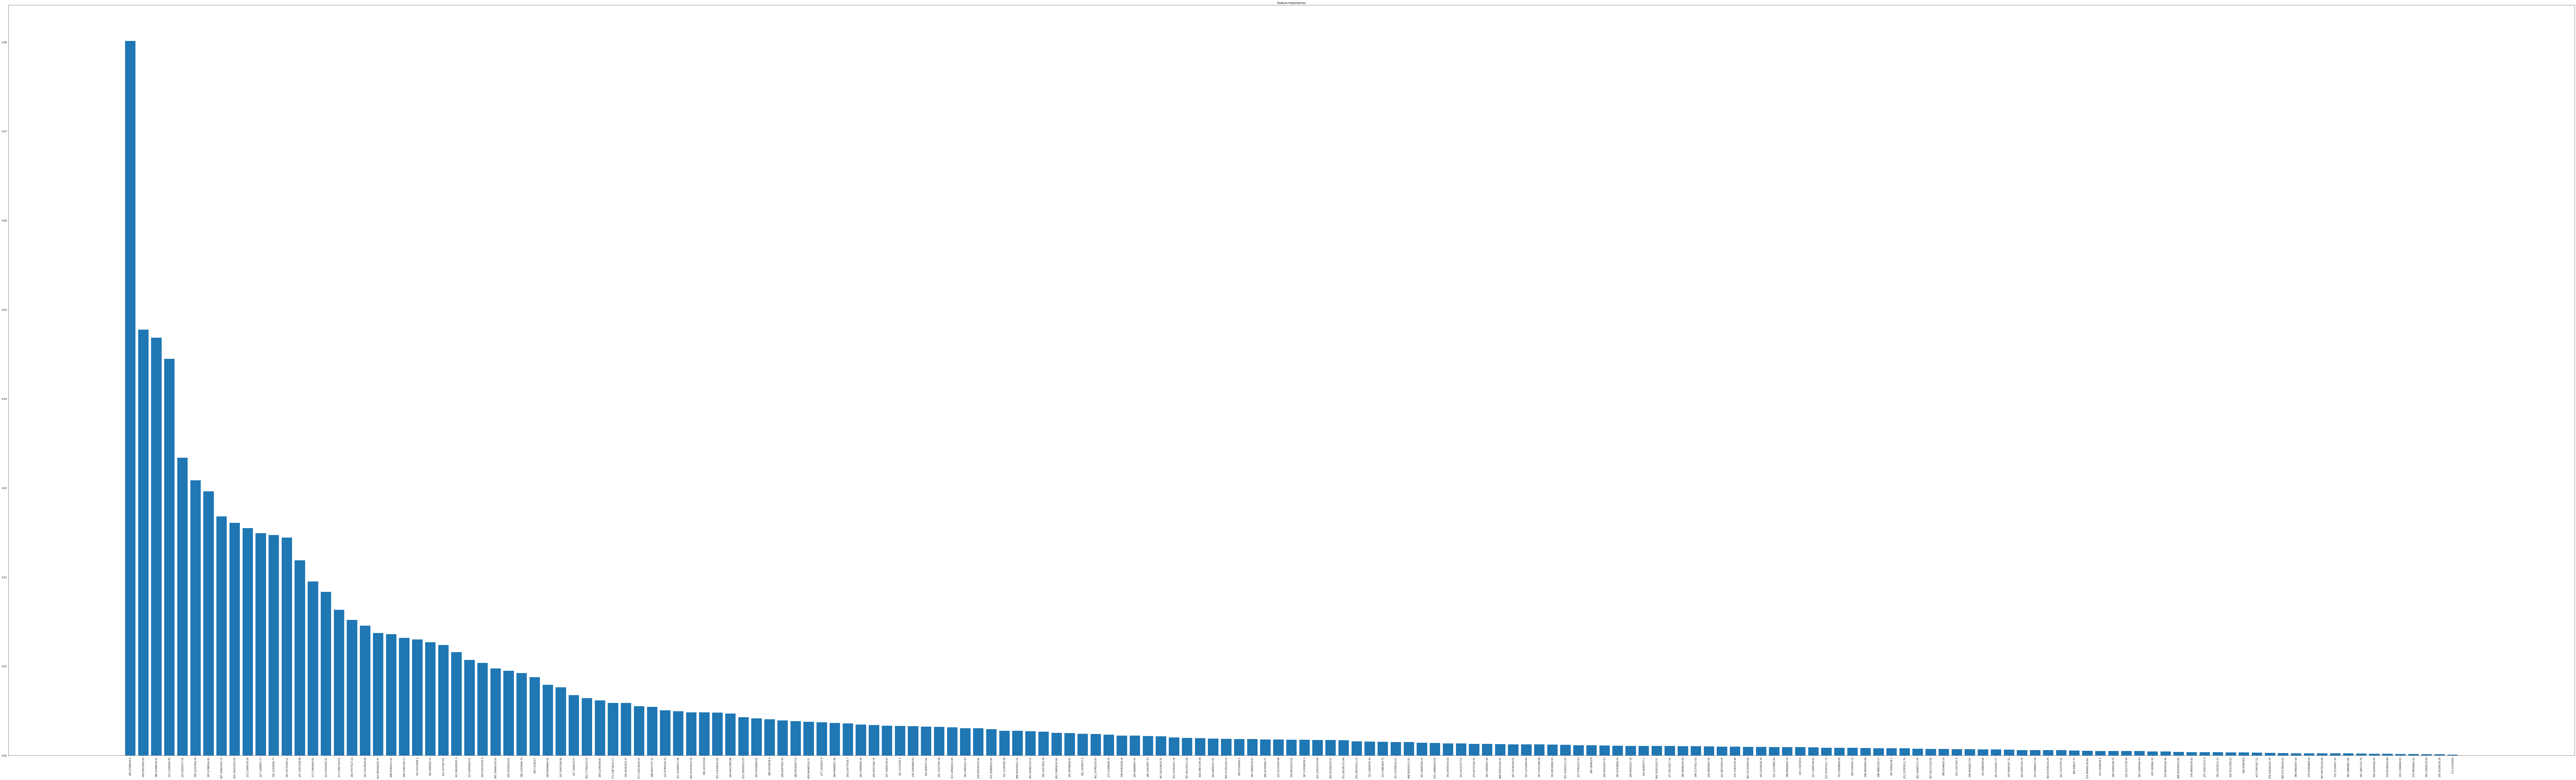

In [65]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_WWTP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_WWTP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [67]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_WWTP.xlsx', index=False)

In [68]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = RandomForestClassifier(n_estimators = 100, max_features = 'log2')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [69]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [70]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


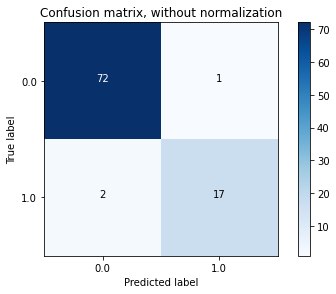

Normalized confusion matrix


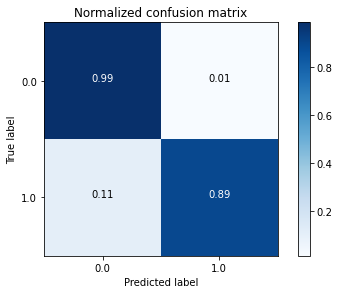

In [71]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For PP

In [72]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [73]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PP


In [74]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [75]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [76]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Random Forest 
n_estimators = [100,1000, 2000]
max_features = ['sqrt', 'log2', 'auto']
#min_samples_leaf = [3, 4, 5]
#min_samples_split = [2, 4]
#bootstrap = [True, False]

#Create a custom scorer for balanced accuracy
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

grid = dict(n_estimators = n_estimators, max_features = max_features)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))

for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = RandomForestClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Random Forest model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.921667 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.908333 using {'max_features': 'auto', 'n_estimators': 1000}
Best: 0.916667 using {'max_features': 'auto', 'n_estimators': 100}
Best: 0.925000 using {'max_features': 'log2', 'n_estimators': 1000}
Best: 0.940000 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.945000 using {'max_features': 'auto', 'n_estimators': 1000}
Best: 0.926667 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.923333 using {'max_features': 'log2', 'n_estimators': 1000}
Best: 0.953333 using {'max_features': 'auto', 'n_estimators': 2000}
Best: 0.931667 using {'max_features': 'log2', 'n_estimators': 1000}


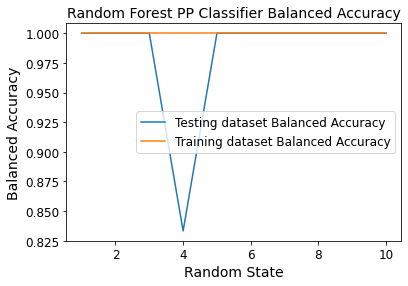

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 1


In [77]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Random Forest PP Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RandomForest-Tuning-T1-PP.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [78]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   1.   0.83 1.   1.   1.   1.   1.   1.  ]


Feature: 0, Score: 0.01143
Feature: 1, Score: 0.00070
Feature: 2, Score: 0.00213
Feature: 3, Score: 0.01075
Feature: 4, Score: 0.00166
Feature: 5, Score: 0.04291
Feature: 6, Score: 0.00073
Feature: 7, Score: 0.00054
Feature: 8, Score: 0.00354
Feature: 9, Score: 0.00279
Feature: 10, Score: 0.00109
Feature: 11, Score: 0.01334
Feature: 12, Score: 0.06224
Feature: 13, Score: 0.01505
Feature: 14, Score: 0.00109
Feature: 15, Score: 0.00031
Feature: 16, Score: 0.00094
Feature: 17, Score: 0.00007
Feature: 18, Score: 0.00591
Feature: 19, Score: 0.00566
Feature: 20, Score: 0.00059
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00024
Feature: 23, Score: 0.00026
Feature: 24, Score: 0.00178
Feature: 25, Score: 0.00689
Feature: 26, Score: 0.00040
Feature: 27, Score: 0.00507
Feature: 28, Score: 0.02509
Feature: 29, Score: 0.00267
Feature: 30, Score: 0.00905
Feature: 31, Score: 0.00012
Feature: 32, Score: 0.05768
Feature: 33, Score: 0.00811
Feature: 34, Score: 0.00053
Feature: 35, Score: 0.00014
Fe

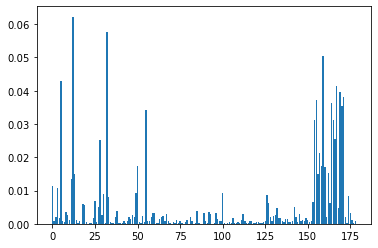

In [79]:
#Now running optimized model over the entire dataset
model = RandomForestClassifier(n_estimators = 1000, max_features = 'auto')
# fit the model
model.fit(data_1, target_1.ravel())
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.01135, Standard Deviation: 0.00144
Feature 1: Average Score: 0.00079, Standard Deviation: 0.00035
Feature 2: Average Score: 0.00155, Standard Deviation: 0.00049
Feature 3: Average Score: 0.01290, Standard Deviation: 0.00161
Feature 4: Average Score: 0.00108, Standard Deviation: 0.00043
Feature 5: Average Score: 0.03463, Standard Deviation: 0.00359
Feature 6: Average Score: 0.00086, Standard Deviation: 0.00041
Feature 7: Average Score: 0.00062, Standard Deviation: 0.00027
Feature 8: Average Score: 0.00389, Standard Deviation: 0.00071
Feature 9: Average Score: 0.00363, Standard Deviation: 0.00078
Feature 10: Average Score: 0.00136, Standard Deviation: 0.00043
Feature 11: Average Score: 0.01518, Standard Deviation: 0.00211
Feature 12: Average Score: 0.06689, Standard Deviation: 0.00501
Feature 13: Average Score: 0.01387, Standard Deviation: 0.00164
Feature 14: Average Score: 0.00081, Standard Deviation: 0.00040
Feature 15: Average Score: 0.00044, Standard Devia

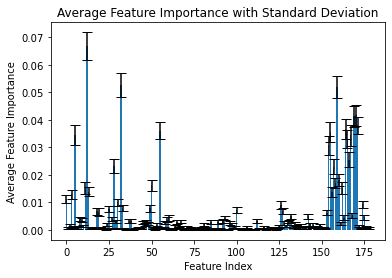

In [80]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=1000, max_features='auto')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [81]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 171.138549/9.93, Mean Score: 0.06689, Standard Deviation: 0.00501
Feature: 254.220132/16.9, Mean Score: 0.05266, Standard Deviation: 0.00439
Feature: 251.200899/15.84, Mean Score: 0.05207, Standard Deviation: 0.00407
Feature: 362.969823/9.44, Mean Score: 0.04164, Standard Deviation: 0.00391
Feature: 331.083458/6.53, Mean Score: 0.04132, Standard Deviation: 0.00390
Feature: 347.243128/14.76, Mean Score: 0.03805, Standard Deviation: 0.00309
Feature: 227.128957/8.02, Mean Score: 0.03674, Standard Deviation: 0.00355
Feature: 171.138736/11.07, Mean Score: 0.03599, Standard Deviation: 0.00311
Feature: 361.237403/16.43, Mean Score: 0.03556, Standard Deviation: 0.00364
Feature: 143.10736/7.81, Mean Score: 0.03463, Standard Deviation: 0.00359


In [82]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 171.138549/9.93, Mean Score: 0.06689, Standard Deviation: 0.00501
Feature: 254.220132/16.9, Mean Score: 0.05266, Standard Deviation: 0.00439
Feature: 251.200899/15.84, Mean Score: 0.05207, Standard Deviation: 0.00407
Feature: 362.969823/9.44, Mean Score: 0.04164, Standard Deviation: 0.00391
Feature: 331.083458/6.53, Mean Score: 0.04132, Standard Deviation: 0.00390
Feature: 347.243128/14.76, Mean Score: 0.03805, Standard Deviation: 0.00309
Feature: 227.128957/8.02, Mean Score: 0.03674, Standard Deviation: 0.00355
Feature: 171.138736/11.07, Mean Score: 0.03599, Standard Deviation: 0.00311
Feature: 361.237403/16.43, Mean Score: 0.03556, Standard Deviation: 0.00364
Feature: 143.10736/7.81, Mean Score: 0.03463, Standard Deviation: 0.00359


Top Features with Significant Importance:
1. Feature: 171.138549/9.93, Mean Score: 0.06689, Standard Deviation: 0.00501
2. Feature: 254.220132/16.9, Mean Score: 0.05266, Standard Deviation: 0.00439
3. Feature: 251.200899/15.84, Mean Score: 0.05207, Standard Deviation: 0.00407
4. Feature: 362.969823/9.44, Mean Score: 0.04164, Standard Deviation: 0.00391
5. Feature: 331.083458/6.53, Mean Score: 0.04132, Standard Deviation: 0.00390
6. Feature: 347.243128/14.76, Mean Score: 0.03805, Standard Deviation: 0.00309
7. Feature: 227.128957/8.02, Mean Score: 0.03674, Standard Deviation: 0.00355
8. Feature: 171.138736/11.07, Mean Score: 0.03599, Standard Deviation: 0.00311
9. Feature: 361.237403/16.43, Mean Score: 0.03556, Standard Deviation: 0.00364
10. Feature: 143.10736/7.81, Mean Score: 0.03463, Standard Deviation: 0.00359
11. Feature: 399.21774/11.63, Mean Score: 0.03433, Standard Deviation: 0.00386
12. Feature: 337.237095/15.07, Mean Score: 0.03309, Standard Deviation: 0.00336
13. Feature: 36

129. Feature: 237.164271/13.4, Mean Score: 0.00042, Standard Deviation: 0.00021


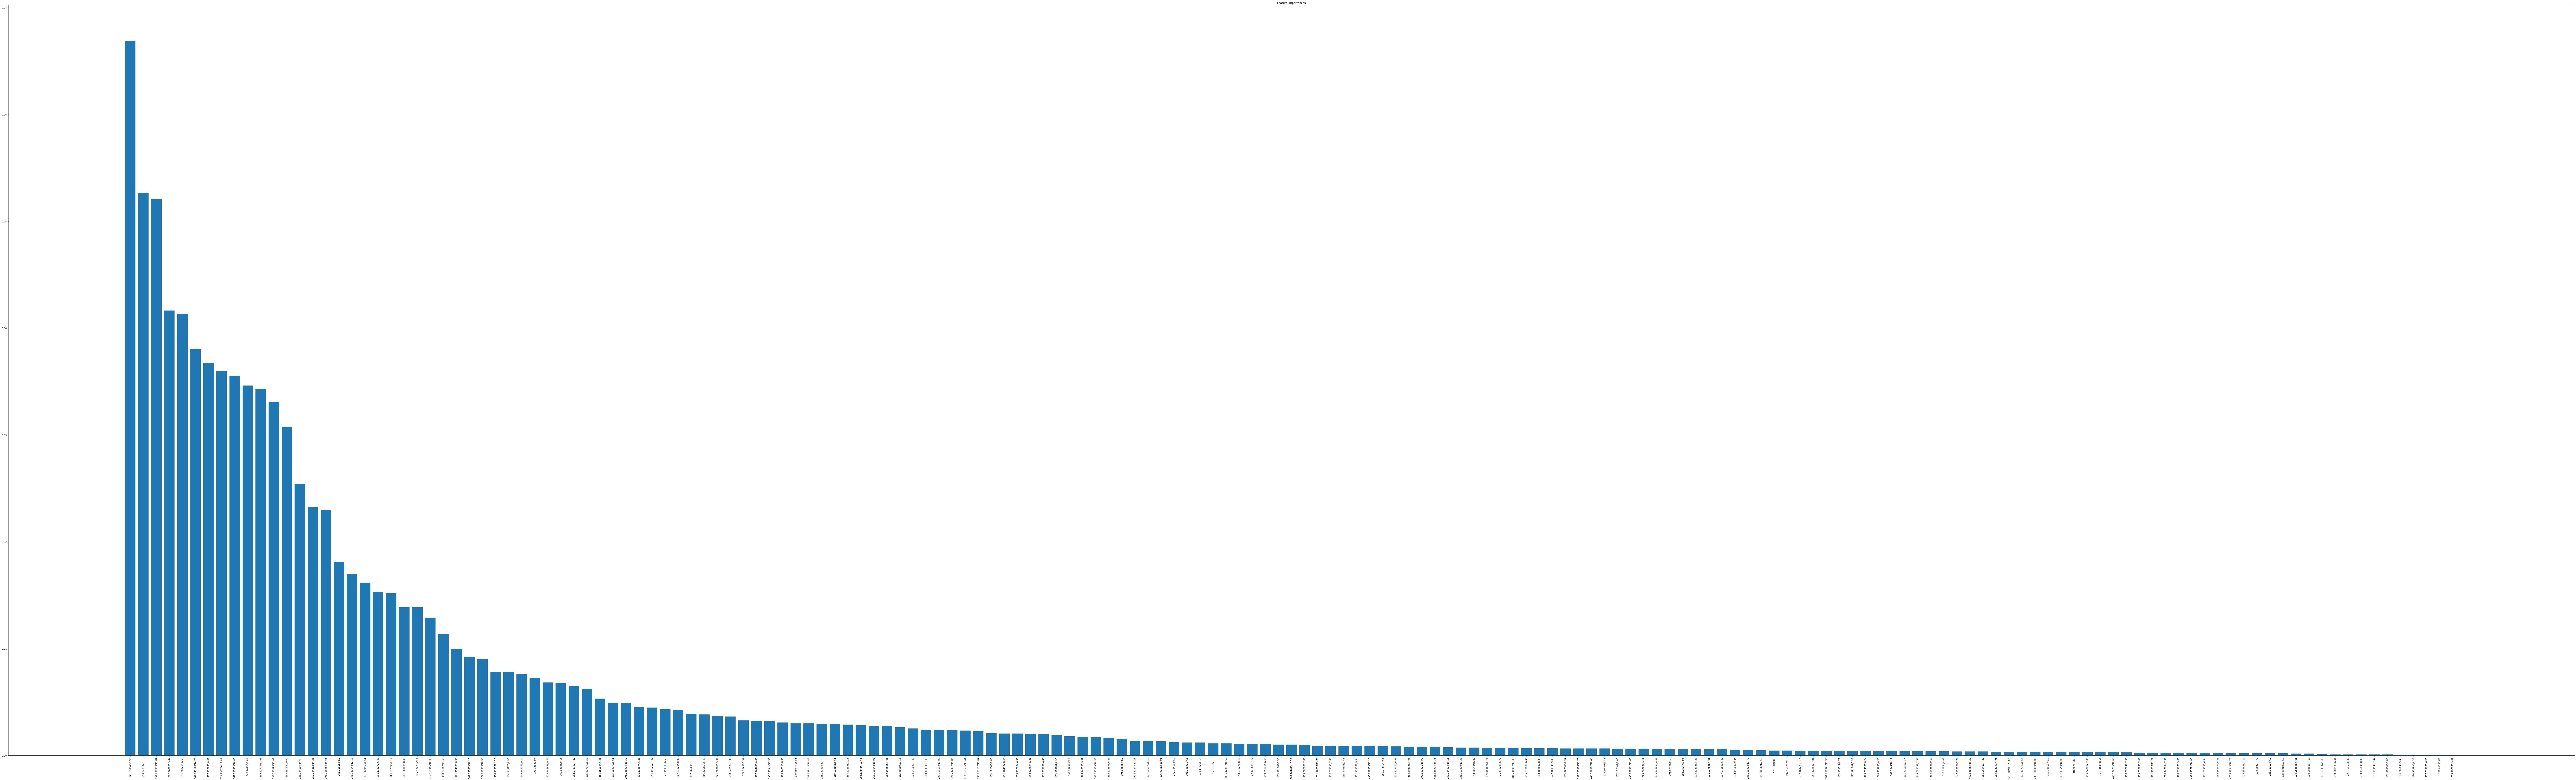

In [83]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_PP.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_PP.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [84]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_PP.xlsx', index=False)

In [85]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = RandomForestClassifier(n_estimators = 1000, max_features = 'auto')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [86]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [87]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


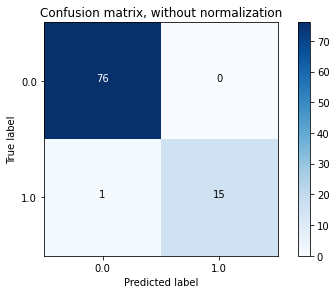

Normalized confusion matrix


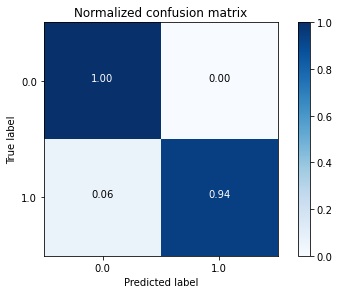

In [88]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)

### For PG

In [89]:
data_rf = pd.read_csv(r'240905-NTA-Paper2-AnnotatedFeatures-ONLY-LogT-Input.csv', header=0) #Targets: 92 samples X 581 features
#del data_rf[data_rf.columns[0]] #Dropping sample information
#print(data_rf)

In [90]:
#Prompt user for source type of interest (GW, LF, BSL, WWTP, PP or PG)
preferred_type = input("Enter the source type of interest: ")

Enter the source type of interest: PG


In [91]:
#Manipulating data frame based on user input to make "Type" column read 1 for all samples of source of interest and 0 for all other samples
#Set up for binary classification (one-vs-all format)

# Define a function to apply to each row
def set_type(row):
    if row['Type'] == preferred_type:
        return 1
    else:
        return 0

# Create a new column "Type 2" with the updated values
data_rf['Type_2'] = data_rf.apply(set_type, axis=1)
del data_rf[data_rf.columns[0]] #Dropping original type column
#Reordering columns with Type_2 as first column
cols = list(data_rf.columns)
cols = [cols[-1]] + cols[:-1]
data_rf = data_rf[cols]

# Save the updated DataFrame to a new CSV file (if needed)
data_rf.to_csv('sample_data_with_labels_NEW10.csv', index=False)

In [92]:
#Changing pandas data frame to numpy for use in ML
data_rf_np = data_rf.to_numpy()
target_1 = data_rf_np[:,0].reshape(-1,1) #Convert target variables to 2D-array for sci-kit learn
data_1 = data_rf_np[:,1:]
#class_names=np.array([0.0,1.0])
#print(data_1.shape)
#print(data_1)

In [93]:
# Split into test and training, and evaluate optimal hyperparameters for Random Forest
totalR = 10
rs = np.arange(1, totalR + 1)

# Define hyperparameter grid for Random Forest 
n_estimators = [100,1000, 2000]
max_features = ['sqrt', 'log2', 'auto']
#min_samples_leaf = [3, 4, 5]
#min_samples_split = [2, 4]
#bootstrap = [True, False]

#Create a custom scorer for balanced accuracy
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

grid = dict(n_estimators = n_estimators, max_features = max_features)
# Initialize arrays to store results
test_balanced_accuracy = np.empty(len(rs))
train_balanced_accuracy = np.empty(len(rs))

for j in rs:
    X_train, X_test, y_train, y_test = train_test_split(
        data_1, target_1, test_size=0.2, stratify=target_1, random_state=j)
    
    # Create Random Forest classifier
    rf = RandomForestClassifier()
    
    # Create repeated stratified k-fold cross-validator
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Perform hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=cv, scoring=balanced_accuracy_scorer, error_score=0)
    grid_result = grid_search.fit(X_train, y_train.ravel())
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Get the best Random Forest model from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Compute balanced accuracy on the training and test data
    train_predictions = best_rf.predict(X_train)
    test_predictions = best_rf.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, train_predictions)
    test_ba = balanced_accuracy_score(y_test, test_predictions)
    
    train_balanced_accuracy[j-1] = train_ba
    test_balanced_accuracy[j-1] = test_ba

Best: 0.600000 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.683333 using {'max_features': 'sqrt', 'n_estimators': 2000}
Best: 0.733333 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.766667 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.700000 using {'max_features': 'sqrt', 'n_estimators': 2000}
Best: 0.583333 using {'max_features': 'sqrt', 'n_estimators': 100}
Best: 0.683333 using {'max_features': 'auto', 'n_estimators': 100}
Best: 0.583333 using {'max_features': 'sqrt', 'n_estimators': 1000}
Best: 0.783333 using {'max_features': 'auto', 'n_estimators': 2000}
Best: 0.566667 using {'max_features': 'sqrt', 'n_estimators': 100}


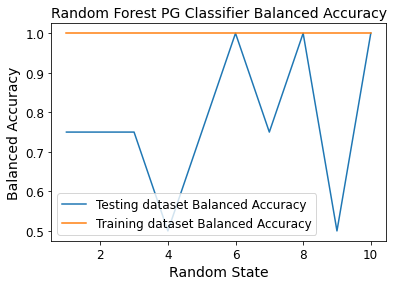

Best Testing Balanced Accuracy: 1.0
Corresponding Random State: 6


In [94]:
# Plot balanced accuracy for different random states
plt.plot(rs, test_balanced_accuracy, label='Testing dataset Balanced Accuracy')
plt.plot(rs, train_balanced_accuracy, label='Training dataset Balanced Accuracy')

plt.legend(fontsize=12)
plt.title('Random Forest PG Classifier Balanced Accuracy', fontsize=14)
plt.xlabel('Random State', fontsize=14)
plt.ylabel('Balanced Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RandomForest-Tuning-PG.png', dpi=150, bbox_inches='tight')
plt.show()

# Print the value of best balanced accuracy and the corresponding random state
best_test_balanced_accuracy = np.max(test_balanced_accuracy)
best_random_state = rs[np.argmax(test_balanced_accuracy)]
print("Best Testing Balanced Accuracy:", best_test_balanced_accuracy)
print("Corresponding Random State:", best_random_state)

In [95]:
print(train_balanced_accuracy)
print(test_balanced_accuracy)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.75 0.75 0.75 0.5  0.75 1.   0.75 1.   0.5  1.  ]


Feature: 0, Score: 0.00910
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00153
Feature: 3, Score: 0.00779
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.02459
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00090
Feature: 8, Score: 0.00124
Feature: 9, Score: 0.00756
Feature: 10, Score: 0.00057
Feature: 11, Score: 0.02509
Feature: 12, Score: 0.02445
Feature: 13, Score: 0.00844
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.01027
Feature: 19, Score: 0.01498
Feature: 20, Score: 0.00172
Feature: 21, Score: 0.00133
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00319
Feature: 25, Score: 0.01250
Feature: 26, Score: 0.00320
Feature: 27, Score: 0.01003
Feature: 28, Score: 0.01303
Feature: 29, Score: 0.00698
Feature: 30, Score: 0.01457
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.01419
Feature: 33, Score: 0.01738
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

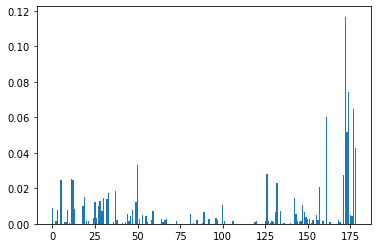

In [96]:
#Now running optimized model over the entire dataset
model = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
# fit the model
model.fit(data_1, target_1.ravel())
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature 0: Average Score: 0.00676, Standard Deviation: 0.00374
Feature 1: Average Score: 0.00143, Standard Deviation: 0.00168
Feature 2: Average Score: 0.00192, Standard Deviation: 0.00193
Feature 3: Average Score: 0.01080, Standard Deviation: 0.00534
Feature 4: Average Score: 0.00191, Standard Deviation: 0.00183
Feature 5: Average Score: 0.02218, Standard Deviation: 0.00723
Feature 6: Average Score: 0.00122, Standard Deviation: 0.00166
Feature 7: Average Score: 0.00165, Standard Deviation: 0.00195
Feature 8: Average Score: 0.00567, Standard Deviation: 0.00310
Feature 9: Average Score: 0.00254, Standard Deviation: 0.00204
Feature 10: Average Score: 0.00206, Standard Deviation: 0.00191
Feature 11: Average Score: 0.01832, Standard Deviation: 0.00666
Feature 12: Average Score: 0.02265, Standard Deviation: 0.00830
Feature 13: Average Score: 0.01639, Standard Deviation: 0.00631
Feature 14: Average Score: 0.00111, Standard Deviation: 0.00143
Feature 15: Average Score: 0.00080, Standard Devia

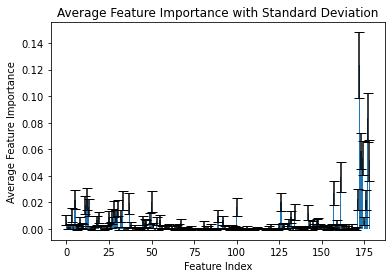

In [97]:
# Initialize variables to store feature importances across iterations
all_importances = []

# Number of iterations
num_iterations = 100

for iteration in range(num_iterations):
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
    model.fit(data_1, target_1.ravel())

    # Get importance and store in the list
    importance = model.feature_importances_
    all_importances.append(importance)

# Convert the list to a NumPy array for easy calculations
all_importances = np.array(all_importances)

# Calculate average and standard deviation of feature importances
average_importance = np.mean(all_importances, axis=0)
std_importance = np.std(all_importances, axis=0)

# Summarize and print feature importance statistics
for i, (avg_score, std_score) in enumerate(zip(average_importance, std_importance)):
    print(f'Feature {i}: Average Score: {avg_score:.5f}, Standard Deviation: {std_score:.5f}')

# Plot the average feature importance
plt.bar([x for x in range(len(average_importance))], average_importance, yerr=std_importance, capsize=5)
plt.xlabel('Feature Index')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance with Standard Deviation')
plt.show()

In [98]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

# Get indices of the top 10 features based on mean importance
top_10_indices = np.argsort(average_importance)[::-1][:10]

# Print top 10 features along with their average and standard deviation
print("Top 10 Features:")
for i in top_10_indices:
    print(f'Feature: {feature_names[i]}, Mean Score: {average_importance[i]:.5f}, Standard Deviation: {std_importance[i]:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 0.12326, Standard Deviation: 0.02486
Feature: 126.90497/17.2, Mean Score: 0.08385, Standard Deviation: 0.01868
Feature: 126.904941/20.82, Mean Score: 0.05870, Standard Deviation: 0.01327
Feature: 309.157653/10.13, Mean Score: 0.05320, Standard Deviation: 0.01271
Feature: 353.30543/16.02, Mean Score: 0.05167, Standard Deviation: 0.01541
Feature: 211.169636/13.44, Mean Score: 0.03920, Standard Deviation: 0.01112
Feature: 301.216358/16.65, Mean Score: 0.02712, Standard Deviation: 0.00879
Feature: 171.138549/9.93, Mean Score: 0.02265, Standard Deviation: 0.00830
Feature: 347.243128/14.76, Mean Score: 0.02248, Standard Deviation: 0.00796
Feature: 143.10736/7.81, Mean Score: 0.02218, Standard Deviation: 0.00723


In [99]:
labels_dat = pd.read_csv("240905-NTA-Paper2-AnnotatedFeatures-ONLY-Labels.csv")
feature_names = labels_dat.columns

feature_importance_pairs = [(avg, std, name) for avg, std, name in zip(average_importance, std_importance, feature_names)]

# Sort the list by average importance in descending order
feature_importance_pairs.sort(reverse=True, key=lambda x: x[0])

# Print the output for the top 10 features
print("Top 10 Features:")
for avg, std, name in feature_importance_pairs[:10]:
    print(f'Feature: {name}, Mean Score: {avg:.5f}, Standard Deviation: {std:.5f}')

Top 10 Features:
Feature: 126.90512/19.91, Mean Score: 0.12326, Standard Deviation: 0.02486
Feature: 126.90497/17.2, Mean Score: 0.08385, Standard Deviation: 0.01868
Feature: 126.904941/20.82, Mean Score: 0.05870, Standard Deviation: 0.01327
Feature: 309.157653/10.13, Mean Score: 0.05320, Standard Deviation: 0.01271
Feature: 353.30543/16.02, Mean Score: 0.05167, Standard Deviation: 0.01541
Feature: 211.169636/13.44, Mean Score: 0.03920, Standard Deviation: 0.01112
Feature: 301.216358/16.65, Mean Score: 0.02712, Standard Deviation: 0.00879
Feature: 171.138549/9.93, Mean Score: 0.02265, Standard Deviation: 0.00830
Feature: 347.243128/14.76, Mean Score: 0.02248, Standard Deviation: 0.00796
Feature: 143.10736/7.81, Mean Score: 0.02218, Standard Deviation: 0.00723


Top Features with Significant Importance:
1. Feature: 126.90512/19.91, Mean Score: 0.12326, Standard Deviation: 0.02486
2. Feature: 126.90497/17.2, Mean Score: 0.08385, Standard Deviation: 0.01868
3. Feature: 126.904941/20.82, Mean Score: 0.05870, Standard Deviation: 0.01327
4. Feature: 309.157653/10.13, Mean Score: 0.05320, Standard Deviation: 0.01271
5. Feature: 353.30543/16.02, Mean Score: 0.05167, Standard Deviation: 0.01541
6. Feature: 211.169636/13.44, Mean Score: 0.03920, Standard Deviation: 0.01112
7. Feature: 301.216358/16.65, Mean Score: 0.02712, Standard Deviation: 0.00879
8. Feature: 171.138549/9.93, Mean Score: 0.02265, Standard Deviation: 0.00830
9. Feature: 347.243128/14.76, Mean Score: 0.02248, Standard Deviation: 0.00796
10. Feature: 143.10736/7.81, Mean Score: 0.02218, Standard Deviation: 0.00723
11. Feature: 395.243372/18, Mean Score: 0.02171, Standard Deviation: 0.00766
12. Feature: 254.219779/16.7, Mean Score: 0.02155, Standard Deviation: 0.00724
13. Feature: 121.0

105. Feature: 219.174255/14, Mean Score: 0.00080, Standard Deviation: 0.00120
106. Feature: 448.933549/10.08, Mean Score: 0.00078, Standard Deviation: 0.00118
107. Feature: 265.143735/9.39, Mean Score: 0.00078, Standard Deviation: 0.00120
108. Feature: 333.206086/8.06, Mean Score: 0.00077, Standard Deviation: 0.00126
109. Feature: 348.939634/8, Mean Score: 0.00075, Standard Deviation: 0.00119
110. Feature: 360.939933/8.25, Mean Score: 0.00073, Standard Deviation: 0.00108
111. Feature: 398.896966/9.19, Mean Score: 0.00071, Standard Deviation: 0.00107
112. Feature: 497.945792/14.08, Mean Score: 0.00070, Standard Deviation: 0.00116
113. Feature: 227.128957/8.02, Mean Score: 0.00070, Standard Deviation: 0.00127
114. Feature: 469.972785/10.63, Mean Score: 0.00066, Standard Deviation: 0.00115
115. Feature: 383.351339/20.58, Mean Score: 0.00064, Standard Deviation: 0.00099
116. Feature: 429.248717/8.38, Mean Score: 0.00062, Standard Deviation: 0.00087
117. Feature: 189.091969/7.53, Mean Score

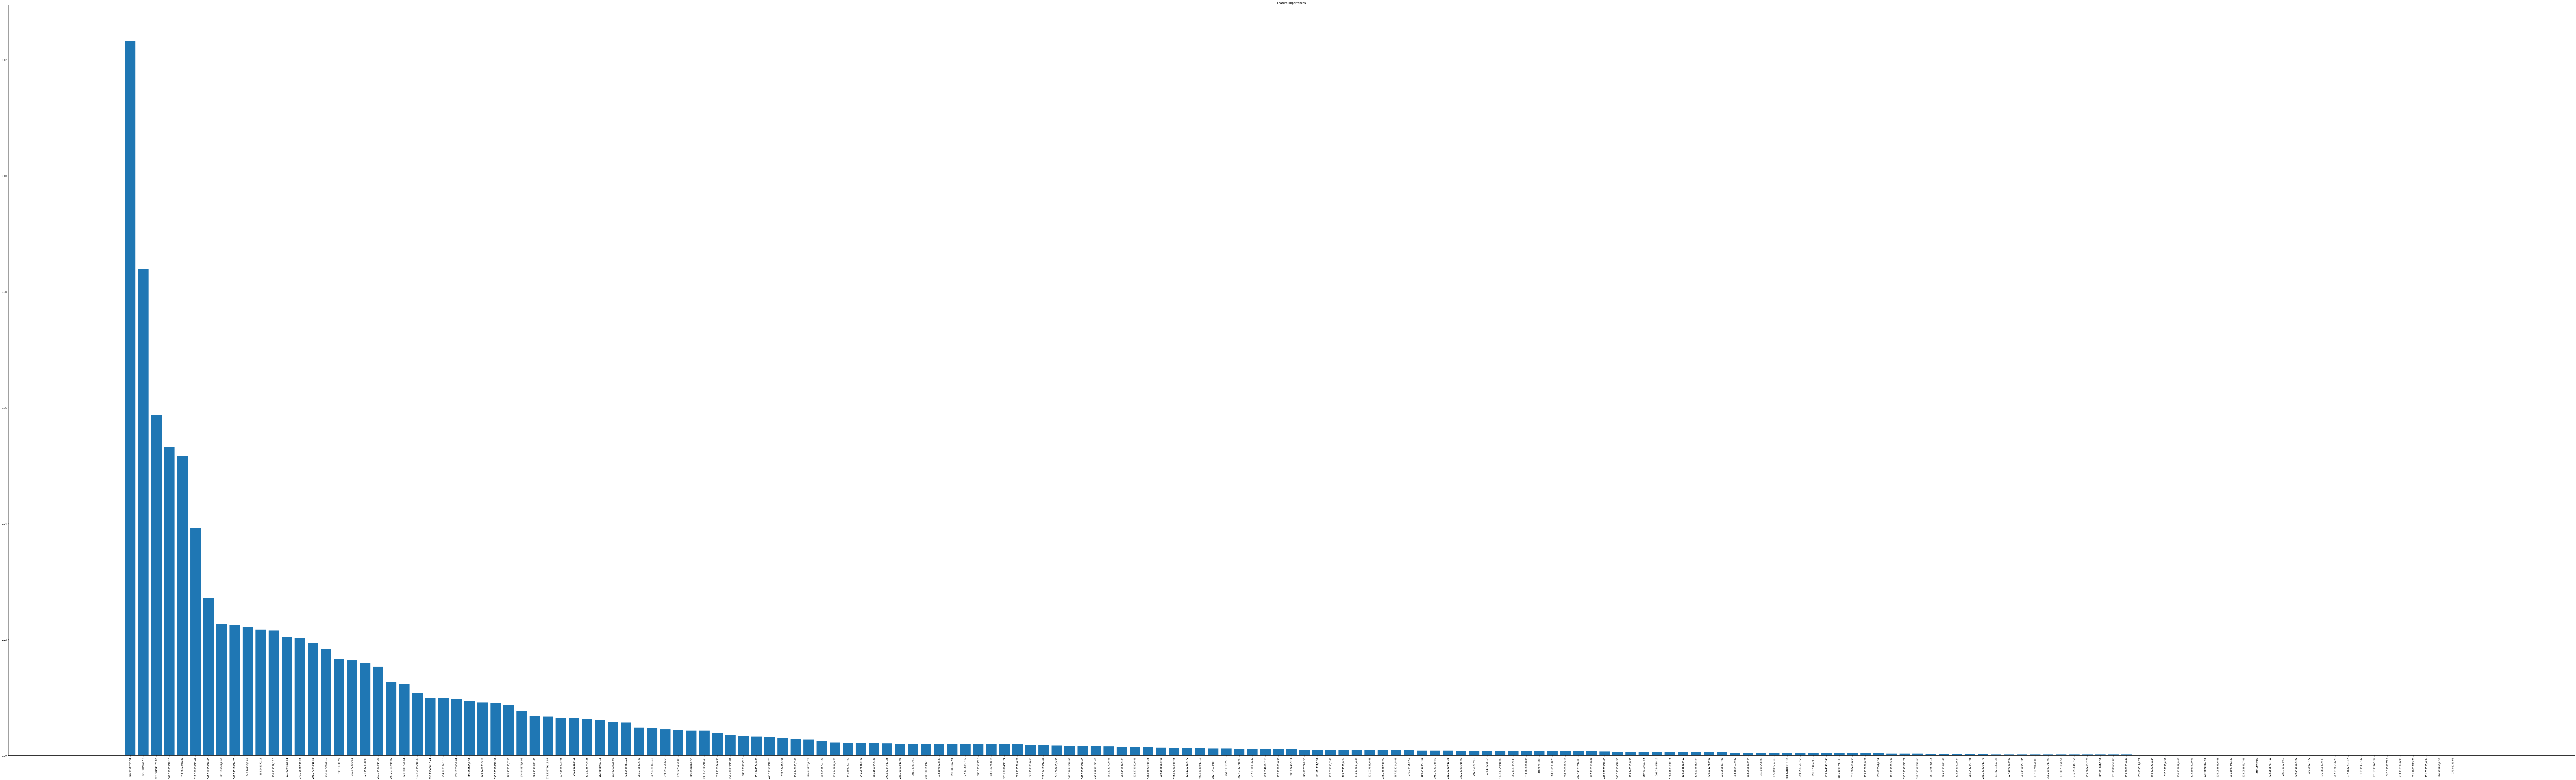

In [100]:
# Rank features by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, reverse=True, key=lambda x: x[0])

# Extract feature names and importances
sorted_importances, _, sorted_feature_names = zip(*sorted_feature_importance_pairs)

# Convert feature importances to a numeric data type
sorted_importances = np.array(sorted_importances, dtype=float)

# Calculate the difference between subsequent feature importances
importance_diff = np.diff(sorted_importances)

# Find the index where the largest decrease occurs
largest_decrease_index = np.argmax(importance_diff)


# Store the top features and scores in a DataFrame
df_top_features = pd.DataFrame({'Feature': [], 'Score': []})

# Print the top features until the largest decrease
print("Top Features with Significant Importance:")
for i, (avg, std, name) in enumerate(sorted_feature_importance_pairs[:largest_decrease_index + 1], 1):
    try:
        avg_float = float(avg)
        print(f"{i}. Feature: {name}, Mean Score: {avg_float:.5f}, Standard Deviation: {std:.5f}")
        df_top_features = df_top_features.append({'Feature': name, 'Score': avg_float}, ignore_index=True)
    except ValueError:
        print(f"{i}. Feature: {name}, Mean Score: {avg}, Standard Deviation: {std} (non-numeric)")

# Save the df_top_features DataFrame to an Excel file
df_top_features.to_excel('top_features_scores_PG.xlsx', index=False)

# Plot feature importance
plt.figure(figsize=(200, 60))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Importances")
# Save the figure as a PNG file
plt.savefig('feature_importances_plot_ORDERED_PG.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [101]:
df = pd.DataFrame({'Importance Difference': importance_diff})
df.to_excel('importance_diff_PG.xlsx', index=False)

In [102]:
class_names=np.array([0.0,1.0])

#Generating confusion matrices (for entire dataset; normalized BAs)
def evaluate_model(data_x, data_y):
    k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x, data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        model_cv = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
        classifier = model_cv.fit(train_x, train_y.ravel())

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [103]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [104]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


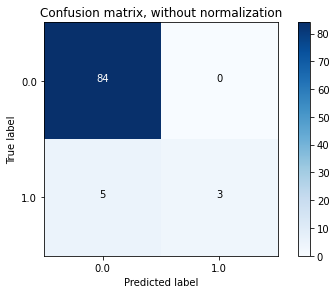

Normalized confusion matrix


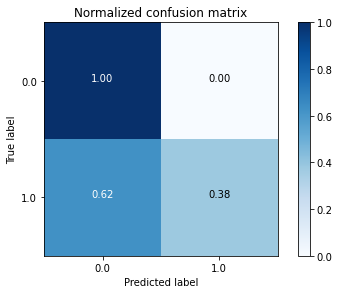

In [105]:
predicted_target, actual_target = evaluate_model(data_1, target_1)
plot_confusion_matrix(predicted_target, actual_target)